## Introduction

`calabru` is a model calibration package.

A basic working example is presented to demonstrate the package.

Let's consider a simple beam model created in Python using PyCBA(https://ccaprani.github.io/pycba/notebooks/intro.html) module. We begin with some necessary imports:

In [1]:
import calabru as clb # calabru package
import numpy as np # for numerical arrays
import matplotlib.pyplot as plt # for plotting
from IPython import display # For images in notebook
import pycba as cba # for creating beam model
%matplotlib inline 

The beam model represents a two span bridge, with a UDL of 20 kN/m acting on each span.

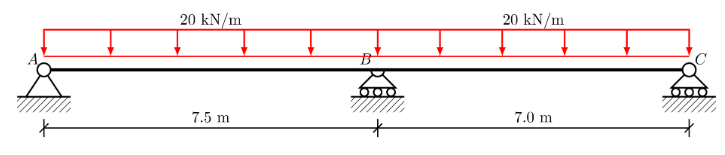

In [2]:
display.Image("../images/pycba_example.png",width=800)

For the calibration problem, we wish to update the model such that the simulated deflection at midspan of Span 1, when subjected to the 20kN/m UDL, matches closely with a known target measurement. We define this target measurement be the deflection obtained from the original example:

In [3]:
m = 1
milli = 1e-3
target_deflections = [- 2.06 * milli*m]

The model is updated by tuning the bending stiffness parameter (EI).

In [4]:
EI_start = [20 * 600e7 * 1e-6]  

### Workflow

A minimal workflow of `calabru` consist of the following steps:

1. Create a function handler for the model that will be updated.

In [5]:
def create_pycba(parameters):
    # init parameters according to PyCBA
    EI = parameters[0]
    LM = [[1, 1,  20, 0, 0], [2, 1, 20, 0, 0]]
    L = [7.5, 7.0]
    R = [-1, 0, -1, 0, -1, 0]
    
    # PyCBA commands
    beam_analysis = cba.BeamAnalysis(L, EI, R, LM)
    beam_analysis.analyze()
    
    # get the target response i.e. the maximum deflection at midspan of Span 1 (7.5m) - index = 44
    deflection_responses = [beam_analysis.beam_results.results.D[44]] 

    return deflection_responses

As can be seen, `create_pycba` is a function handler 
which creates and analyzes the PyCBA beam model. The function handler must have the following feature:
- Updating parameters as a list/array.
- returns the model output that corresponds to the target measurements as a list/array.

For this example, `parameters` is the list input argument of the bending stiffness while `deflection_responses` is the list of deflection output from the beam model.

2. Invoke the `ModelUpdating` class.

In [6]:
update_process = clb.ModelUpdating(
                                    function_handle=create_pycba, 
                                    param_list=EI_start,
                                    target_list=target_deflections,
                                    max_error=0.01,
                                    )

3. Run the class function to update model.

In [7]:
param_history, resp_history  = update_process.update_model()

where `param_history` is the updating history of the given model parameters, and `resp_history` is the history of differences between model and target measurements for each updating step.

Alternatively, we can directly access the class variables of `update_process` (primarily list/arrays). As such, the parameters and residuls can be use for post-processing later on (e.g., plotting).The typical outputs can be extracted as follows:

In [8]:
# for update history of parameters
update_process.param_update_history 

[[120000.0],
 [164129.0074781965],
 [180289.11776900673],
 [180261.77743457866],
 [180264.5151988686]]

In [9]:
# for history of model differences
update_process.resp_diff_history

[[0.0010345365722656233], [0.0002025152882936033], [-2.839546441430439e-07]]

We can then compare with PyCBA's example, here we get 

In [10]:
EI_pycba = 30 * 600e7 * 1e-6
EI_updated = update_process.param_update_history[-1]

print("The target EI ={}".format(EI_pycba))
print("The updated EI ={:1f}".format(EI_updated[0]))

The target EI =180000.0
The updated EI =180264.515199


which is very close to the example's orginal value for EI.